# Proiect Learning Analytics - Chicago_Crime_Data.csv

Importuri și inițializarea sesiunii Spark

In [86]:
# Instalare PySpark
!pip install -q pyspark

In [87]:
# Importuri generale
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

plt.style.use("default")
sns.set(rc={"figure.figsize": (10, 5)})

# Importuri PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

plt.style.use("default")
sns.set(rc={"figure.figsize": (10, 5)})

# Inițializarea sesiunii Spark
spark = SparkSession.builder \
    .appName("ChicagoCrime_PySpark") \
    .getOrCreate()

spark

Conectarea la Google Drive si calea spre fisier

In [88]:
# Conectare la Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Calea către fișierul CSV
csv_path = "/content/drive/MyDrive/Chicago_Crime_Data.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Încărcarea setului de date în PySpark

In [89]:
# Încărcarea setului de date în DataFrame PySpark
crimes_sdf = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .csv(csv_path)
)

print("Număr de înregistrări:", crimes_sdf.count())
print("Schema dataset-ului:")
crimes_sdf.printSchema()

# Primele 5 înregistrări (preview)
crimes_sdf.show(5, truncate=False)

Număr de înregistrări: 30000
Schema dataset-ului:
root
 |-- unique_key: integer (nullable = true)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: integer (nullable = true)
 |-- district: integer (nullable = true)
 |-- ward: integer (nullable = true)
 |-- community_area: integer (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: integer (nullable = true)
 |-- y_coordinate: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)

+----------+-----------+--------

Curățarea datelor și Feature Engineering

In [90]:
# Curățarea datelor și Feature Engineering pe coloanele reale

# Folosim numele CORECT al coloanelor
cols_required = ["primary_type", "arrest", "date", "district"]

crimes_sdf = crimes_sdf.dropna(subset=cols_required)

# Conversia coloanei date în timestamp
crimes_sdf = crimes_sdf.withColumn(
    "datetime",
    F.to_timestamp("date", "MM/dd/yyyy hh:mm:ss a")
)

# Extragem ani, luni, ore, zi săptămână
crimes_sdf = (
    crimes_sdf
    .withColumn("year", F.year("datetime"))
    .withColumn("month", F.month("datetime"))
    .withColumn("hour", F.hour("datetime"))
    .withColumn("dayofweek", F.date_format("datetime", "E"))
)

print("Număr de înregistrări după curățare:", crimes_sdf.count())

crimes_sdf.select(
    "primary_type", "arrest", "district", "year", "month", "hour", "dayofweek"
).show(5)


Număr de înregistrări după curățare: 30000
+--------------------+------+--------+----+-----+----+---------+
|        primary_type|arrest|district|year|month|hour|dayofweek|
+--------------------+------+--------+----+-----+----+---------+
| CRIM SEXUAL ASSAULT| false|       1|2016|    8|   6|      Fri|
| CRIM SEXUAL ASSAULT| false|       1|2018|    4|  20|      Sat|
| CRIM SEXUAL ASSAULT| false|       1|2018|    3|   9|      Thu|
| CRIM SEXUAL ASSAULT| false|       1|2001|    7|  22|      Sat|
|CRIMINAL SEXUAL A...| false|       1|2022|    5|  22|      Fri|
+--------------------+------+--------+----+-----+----+---------+
only showing top 5 rows



EDA – Analiza exploratorie a datelor

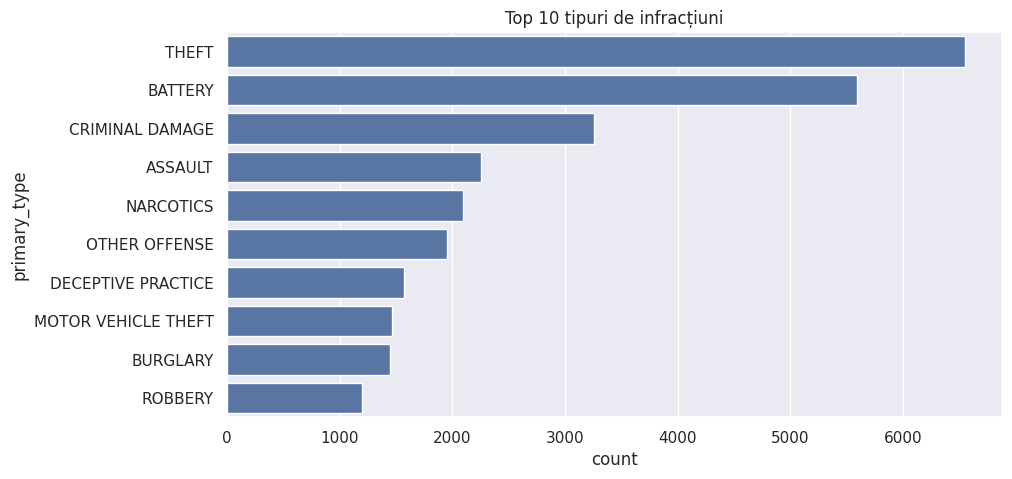

,primary_type,count
0,THEFT,6552
1,BATTERY,5593
2,CRIMINAL DAMAGE,3255
3,ASSAULT,2255
4,NARCOTICS,2095
5,OTHER OFFENSE,1955
6,DECEPTIVE PRACTICE,1574
7,MOTOR VEHICLE THEFT,1463
8,BURGLARY,1444
9,ROBBERY,1197


In [91]:
# Top 10 Tipuri de Infracțiuni
top_types = (
    crimes_sdf
    .groupBy("primary_type")
    .count()
    .orderBy(F.desc("count"))
    .limit(10)
    .toPandas()
)

plt.figure()
sns.barplot(data=top_types, x="count", y="primary_type")
plt.title("Top 10 tipuri de infracțiuni")
plt.show()

top_types

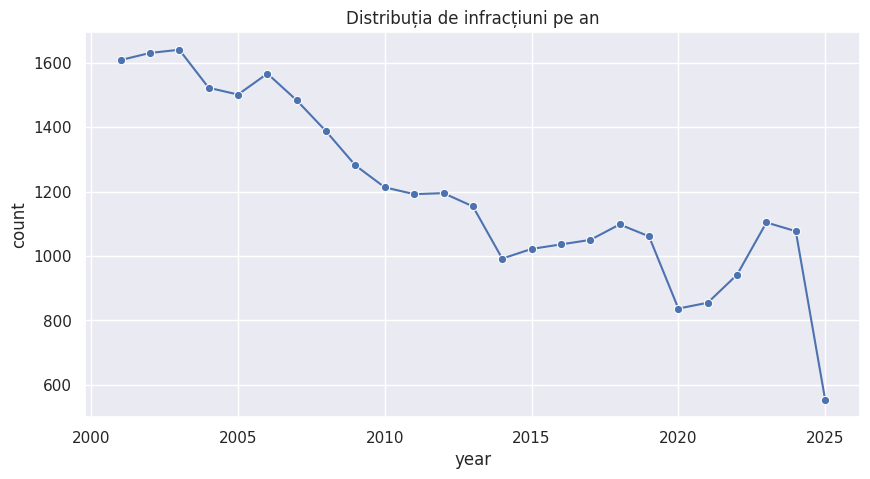

,year,count
0,2001,1608
1,2002,1630
2,2003,1640
3,2004,1522
4,2005,1501
5,2006,1566
6,2007,1483
7,2008,1387
8,2009,1281
9,2010,1213


In [92]:
# Distribuția de infracțiuni pe an
crimes_per_year = (
    crimes_sdf.groupBy("year").count().orderBy("year").toPandas()
)

plt.figure()
sns.lineplot(data=crimes_per_year, x="year", y="count", marker="o")
plt.title("Distribuția de infracțiuni pe an")
plt.show()

crimes_per_year

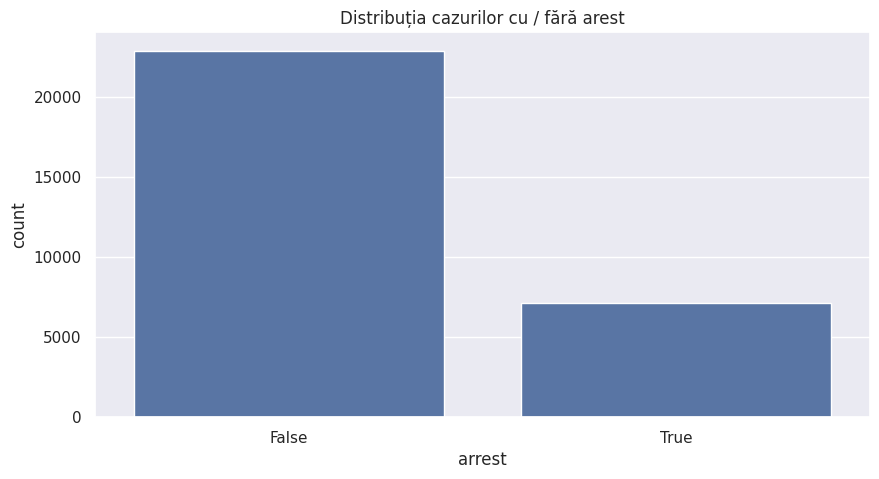

,arrest,count
0,True,7113
1,False,22887


In [93]:
# Distribuția cazurilor cu/ fără arest
arrest_dist = (
    crimes_sdf.groupBy("arrest").count().toPandas()
)

plt.figure()
sns.barplot(data=arrest_dist, x="arrest", y="count")
plt.title("Distribuția cazurilor cu / fără arest")
plt.show()

arrest_dist

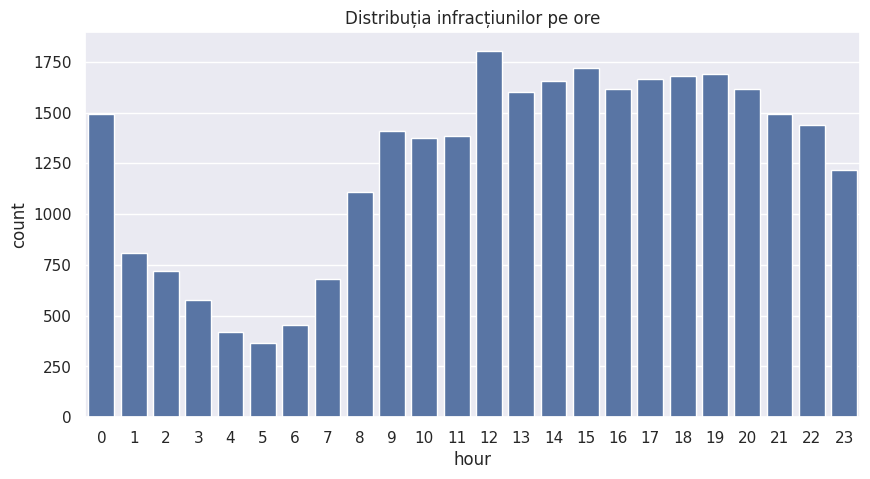

,hour,count
0,0,1495
1,1,809
2,2,719
3,3,578
4,4,422
5,5,367
6,6,455
7,7,682
8,8,1108
9,9,1411


In [94]:
# Distribuția infracțiunilor pe ore
crimes_per_hour = (
    crimes_sdf.groupBy("hour").count().orderBy("hour").toPandas()
)

plt.figure()
sns.barplot(data=crimes_per_hour, x="hour", y="count")
plt.title("Distribuția infracțiunilor pe ore")
plt.show()

crimes_per_hour

Pregătirea datelor pentru Machine Learning

In [95]:
# Pregătirea datelor pentru Machine Learning
ml_cols = ["primary_type", "district", "year", "month", "hour", "dayofweek", "arrest"]

ml_df = crimes_sdf.select(*ml_cols).dropna()

# Convertim BOOLEAN -> INT
ml_df = ml_df.withColumn("arrest_int", F.col("arrest").cast("int"))

cat_cols = ["primary_type", "district", "dayofweek"]
num_cols = ["year", "month", "hour"]
label_col = "arrest_int"   # Label direct numeric, fără StringIndexer

ml_df.show(5)
print("Total rânduri ML:", ml_df.count())


+--------------------+--------+----+-----+----+---------+------+----------+
|        primary_type|district|year|month|hour|dayofweek|arrest|arrest_int|
+--------------------+--------+----+-----+----+---------+------+----------+
| CRIM SEXUAL ASSAULT|       1|2016|    8|   6|      Fri| false|         0|
| CRIM SEXUAL ASSAULT|       1|2018|    4|  20|      Sat| false|         0|
| CRIM SEXUAL ASSAULT|       1|2018|    3|   9|      Thu| false|         0|
| CRIM SEXUAL ASSAULT|       1|2001|    7|  22|      Sat| false|         0|
|CRIMINAL SEXUAL A...|       1|2022|    5|  22|      Fri| false|         0|
+--------------------+--------+----+-----+----+---------+------+----------+
only showing top 5 rows

Total rânduri ML: 30000


Pipeline comun (indexare, encoding, assembler, split)

In [96]:
# Pipeline comun (indexare, encoding, assembler, split)
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_cols
]

encoders = [
    OneHotEncoder(inputCols=[f"{c}_idx"], outputCols=[f"{c}_oh"])
    for c in cat_cols
]

assembler = VectorAssembler(
    inputCols=[f"{c}_oh" for c in cat_cols] + num_cols,
    outputCol="features"
)

train_df, test_df = ml_df.randomSplit([0.7, 0.3], seed=42)

bin_eval = BinaryClassificationEvaluator(
    labelCol=label_col, metricName="areaUnderROC"
)

multi_eval = MulticlassClassificationEvaluator(
    labelCol=label_col, metricName="accuracy"
)

base_stages = indexers + encoders + [assembler]

Funcții auxiliare

In [97]:
# Funcții auxiliare
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de Confuzie – {title}")
    plt.xlabel("Predicții")
    plt.ylabel("Adevăr")
    plt.show()

def compute_metrics(pred_df, label_col, title):
    pdf = pred_df.select(label_col, "prediction", "probability").toPandas()

    y_true = pdf[label_col].astype(int)
    y_pred = pdf["prediction"].astype(int)
    y_prob = pdf["probability"].apply(lambda x: float(x[1]))

    acc = (y_true == y_pred).mean()
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n=== Rezultate {title} ===")
    print(f"Acuratețe: {acc:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    plot_confusion_matrix(y_true, y_pred, title)

    return acc, auc

Model 1 : Logistic Regression


=== Rezultate Logistic Regression ===
Acuratețe: 0.8668
ROC-AUC:   0.8305

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6826
           1       0.88      0.50      0.64      2102

    accuracy                           0.87      8928
   macro avg       0.87      0.74      0.78      8928
weighted avg       0.87      0.87      0.85      8928



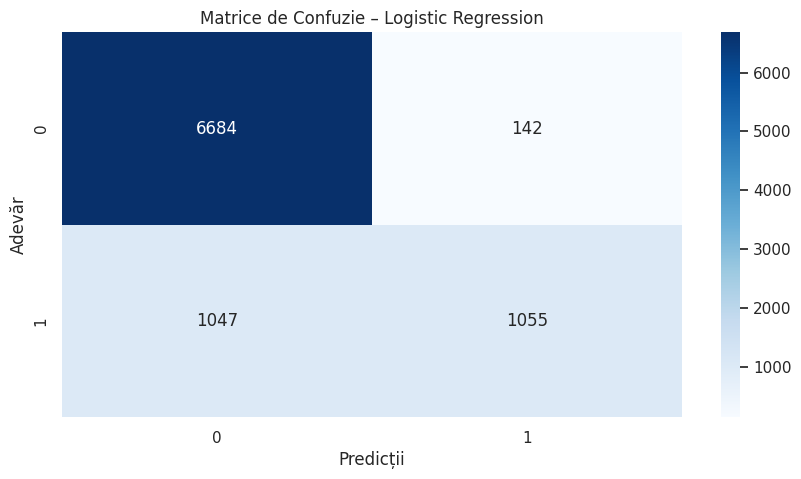

In [98]:
# Logistic Regression
lr = LogisticRegression(
    featuresCol="features",
    labelCol=label_col,
    maxIter=50
)

pipeline_lr = Pipeline(stages=base_stages + [lr])

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1]).build()

cv_lr = CrossValidator(
    estimator=pipeline_lr,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol=label_col),
    numFolds=3
)

model_lr = cv_lr.fit(train_df)
pred_lr = model_lr.transform(test_df)

acc_lr, auc_lr = compute_metrics(pred_lr, label_col, "Logistic Regression")

Model 2 : Random Forest


=== Rezultate Random Forest ===
Acuratețe: 0.8646
ROC-AUC:   0.8324

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      6826
           1       0.93      0.46      0.62      2102

    accuracy                           0.86      8928
   macro avg       0.89      0.73      0.77      8928
weighted avg       0.87      0.86      0.85      8928



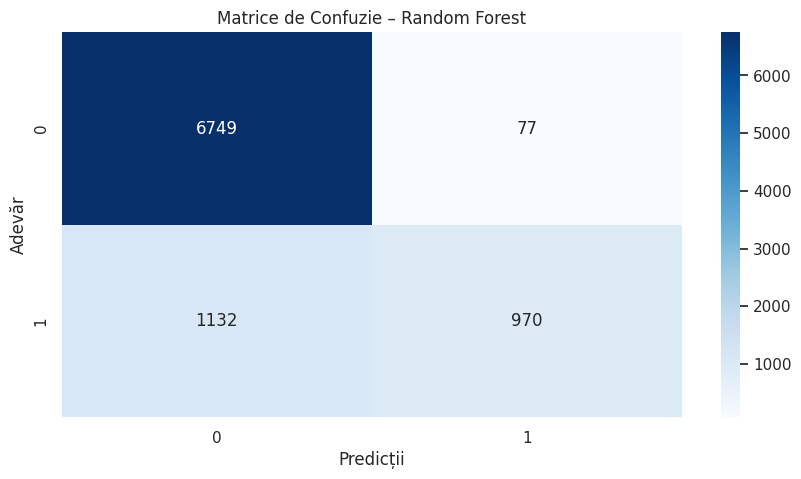

In [99]:
# Random Forest
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol=label_col,
    numTrees=60
)

pipeline_rf = Pipeline(stages=base_stages + [rf])

paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [6, 10]).build()

cv_rf = CrossValidator(
    estimator=pipeline_rf,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol=label_col),
    numFolds=3
)

model_rf = cv_rf.fit(train_df)
pred_rf = model_rf.transform(test_df)

acc_rf, auc_rf = compute_metrics(pred_rf, label_col, "Random Forest")

Model 3 : Gradient Boosted Trees


=== Rezultate GBT ===
Acuratețe: 0.8706
ROC-AUC:   0.8345

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      6826
           1       0.91      0.50      0.64      2102

    accuracy                           0.87      8928
   macro avg       0.89      0.74      0.78      8928
weighted avg       0.88      0.87      0.86      8928



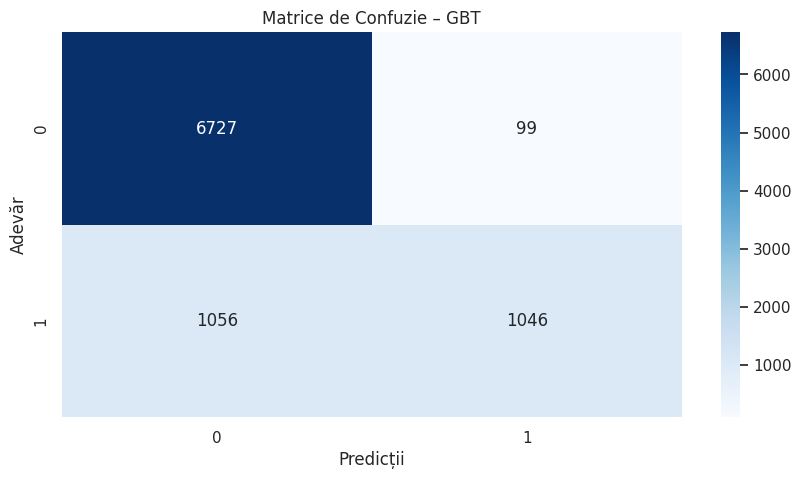

In [100]:
# Gradient Boosted Trees
gbt = GBTClassifier(
    featuresCol="features",
    labelCol=label_col,
    maxIter=40,
    maxDepth=5
)

pipeline_gbt = Pipeline(stages=base_stages + [gbt])

paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth, [3, 5]).build()

cv_gbt = CrossValidator(
    estimator=pipeline_gbt,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol=label_col),
    numFolds=3
)

model_gbt = cv_gbt.fit(train_df)
pred_gbt = model_gbt.transform(test_df)

acc_gbt, auc_gbt = compute_metrics(pred_gbt, label_col, "GBT")

Comparația modelelor - Logistic Regression vs Random Forest vs Gradient Boosted Trees

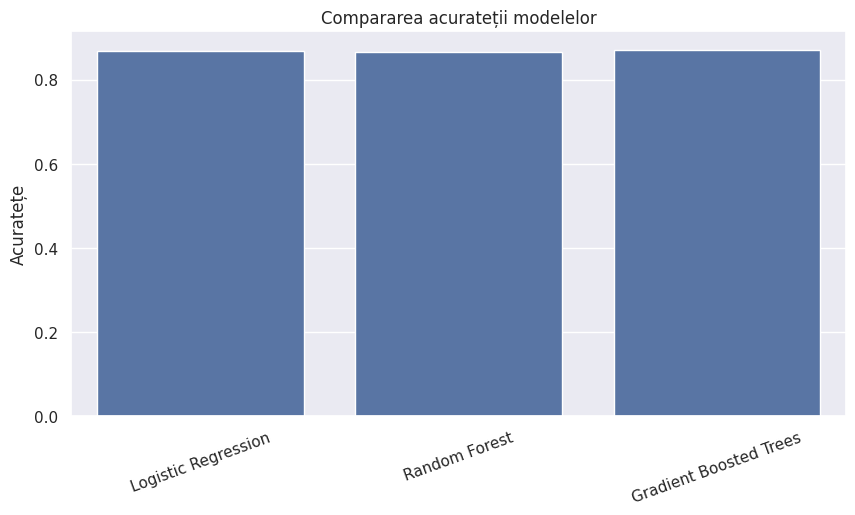


=== Acuratețile modelelor ===
 • Logistic Regression: 0.8668
 • Random Forest: 0.8646
 • Gradient Boosted Trees: 0.8706


In [103]:
# Comparația modelelor - Logistic Regression vs Random Forest vs Gradient Boosted Trees
models = ["Logistic Regression", "Random Forest", "Gradient Boosted Trees"]
accuracies = [acc_lr, acc_rf, acc_gbt]

plt.figure(figsize=(10,5))
sns.barplot(x=models, y=accuracies)
plt.title("Compararea acurateții modelelor")
plt.ylabel("Acuratețe")
plt.xticks(rotation=20)
plt.show()

print("\n=== Acuratețile modelelor ===")
for name, acc in zip(models, accuracies):
    print(f" • {name}: {acc:.4f}")
